# Test model with NDS

In [34]:
import sys
sys.path.append("..")
sys.path.append("../../")
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from model_settings import img_height, img_width, min_blobs_test, max_blobs_test, max_blobs_train, min_blobs_train

In [35]:
margin = 5
spacing = 20
width = height = 3
min_blobs = min_blobs_test # 1
max_blobs = max_blobs_test # 9
output_size = max_blobs_train - min_blobs_train + 1
num_labels = max_blobs - min_blobs + 1 # 10
num_sequences = 1000

In [4]:
NDS_data = np.load("/home/mtfang/increments/data_NDS/NDS_data.npy")
NDS_data = NDS_data.item()
images = NDS_data["images"] # size: (1000,10,10000)
label_saclar = NDS_data["label_scalar"] 

# Test NDS with checkpoints

- use original model of swap tests (PDP Note 6/9/20)
- check /home/mtfang/DRAM/Visualization/Estimation/ClassifyHiddenUnits.ipynb
- swap test code: /home/mtfang/DRAM/FF_estimation_classifier(scalar)_swap.py


In [29]:
# parameters
read_n = 15  # N x N filterbank for each layer
dims = [img_height,img_width] # input_img size
eps = 1e-8 # epsilon for numerical stability
delta_1=max(dims[0],dims[1])/(read_n-1) 
sigma2_1=delta_1*delta_1/4 # sigma=delta/2 
batch_size = 1
run = 1
iter_num = 3000000
MODELNAME = ['CAA_const_fN', 'CAA_decrs_fN', 'DAA_const_fN', 'DAA_decrs_fN']
MODE = MODELNAME[0]
test_run = 1
ckpt_file = "/home/mtfang/DRAM/model_runs/estimation/classifier_model/classifier_"+MODE+"_run"+str(test_run)+"/classifymodel_"+str(iter_num)+".ckpt"

In [28]:
# load pre-trained model
ckpt_reader = tf.train.load_checkpoint(ckpt_file)
hidden_w = ckpt_reader.get_tensor("hidden/w") # size(225,250)
hidden_b = ckpt_reader.get_tensor("hidden/b") # size(250,)
output_w = ckpt_reader.get_tensor("output/w") # size(250,15)
output_b = ckpt_reader.get_tensor("output/b") # size(15,)

In [30]:
def filterbank(gx, gy, N):
    grid_i = np.reshape(np.arange(N), [1, -1])
    mu_x_1 = gx + (grid_i - N / 2 + 0.5) * delta_1 # eq 19 batch_size x N
    mu_y_1 = gy + (grid_i - N / 2 + 0.5) * delta_1 # eq 20 batch_size x N
    a = np.reshape(np.arange(dims[0]), [1, 1, -1]) # 1 x 1 x dims[0]
    b = np.reshape(np.arange(dims[1]), [1, 1, -1]) # 1 x 1 x dims[1]

    mu_x_1 = np.reshape(mu_x_1, [-1, N, 1]) # batch_size x N x 1
    mu_y_1 = np.reshape(mu_y_1, [-1, N, 1])
    Fx_1 = np.exp(-np.square(a - mu_x_1) / (2*sigma2_1)) # batch_size x N x dims[0]
    Fy_1 = np.exp(-np.square(b - mu_y_1) / (2*sigma2_1)) # batch_size x N x dims[1]
    # normalize, sum over A and B dims
    Fx_1=Fx_1/np.maximum(np.sum(Fx_1,2,keepdims=True),eps)
    Fy_1=Fy_1/np.maximum(np.sum(Fy_1,2,keepdims=True),eps)
    return Fx_1, Fy_1, mu_x_1, mu_y_1

def attn_window(scope, N):  
    gx=dims[0]/2  
    gy=dims[1]/2 
    gx=np.reshape([gx]*batch_size, [batch_size,1])
    gy=np.reshape([gy]*batch_size, [batch_size,1])
    Fx_1, Fy_1, mu_x_1, mu_y_1 = filterbank(gx, gy, N)
    return Fx_1, Fy_1, gx, gy


def read(x):
    Fx_1, Fy_1, gx, gy = attn_window("read", read_n)
    stats = Fx_1, Fy_1
    new_stats = gx, gy
    
    def filter_img(img, Fx_1, Fy_1, N):
        Fxt_1 = np.transpose(Fx_1, axes=[0,2,1])
        # img: 1 x img_size
        img = np.reshape(img,[-1, dims[1], dims[0]])
        fimg_1 = np.matmul(Fy_1, np.matmul(img, Fxt_1))
        fimg_1 = np.reshape(fimg_1,[-1, N*N])
        # normalization (if do norm, Pc will be nan)
        # scalar_1 = tf.reshape(tf.reduce_max(fimg_1, 1), [batch_size, 1])
        # fimg_1 = fimg_1/tf.reduce_max(fimg_1, 1, keepdims=True)
        fimg = fimg_1 
        return fimg

    xr = filter_img(x, Fx_1, Fy_1, read_n) # batch_size x (read_n*read_n)
    return xr, new_stats # concat along feature axis

def linear(x, w, b):
    output = np.dot(x, w) + b
    return output

def hidden_activation(x, w, b):
    xr, _ = read(x)
    hidden = np.maximum(0, linear(xr, w, b))
    return hidden

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x) # only difference

def classifier(h, w, b):
    classification = softmax(linear(hidden, w, b))
    return classification

In [41]:
confidence = np.zeros([num_sequences, num_labels+1, output_size])

for s_idx in range(num_sequences): 
    for n_idx in range(num_labels+1):
        x = images[s_idx][n_idx]
        hidden = hidden_activation(x, hidden_w, hidden_b)
        classification = classifier(hidden, output_w, output_b)
        confidence[s_idx][n_idx] = classification

# Visualization

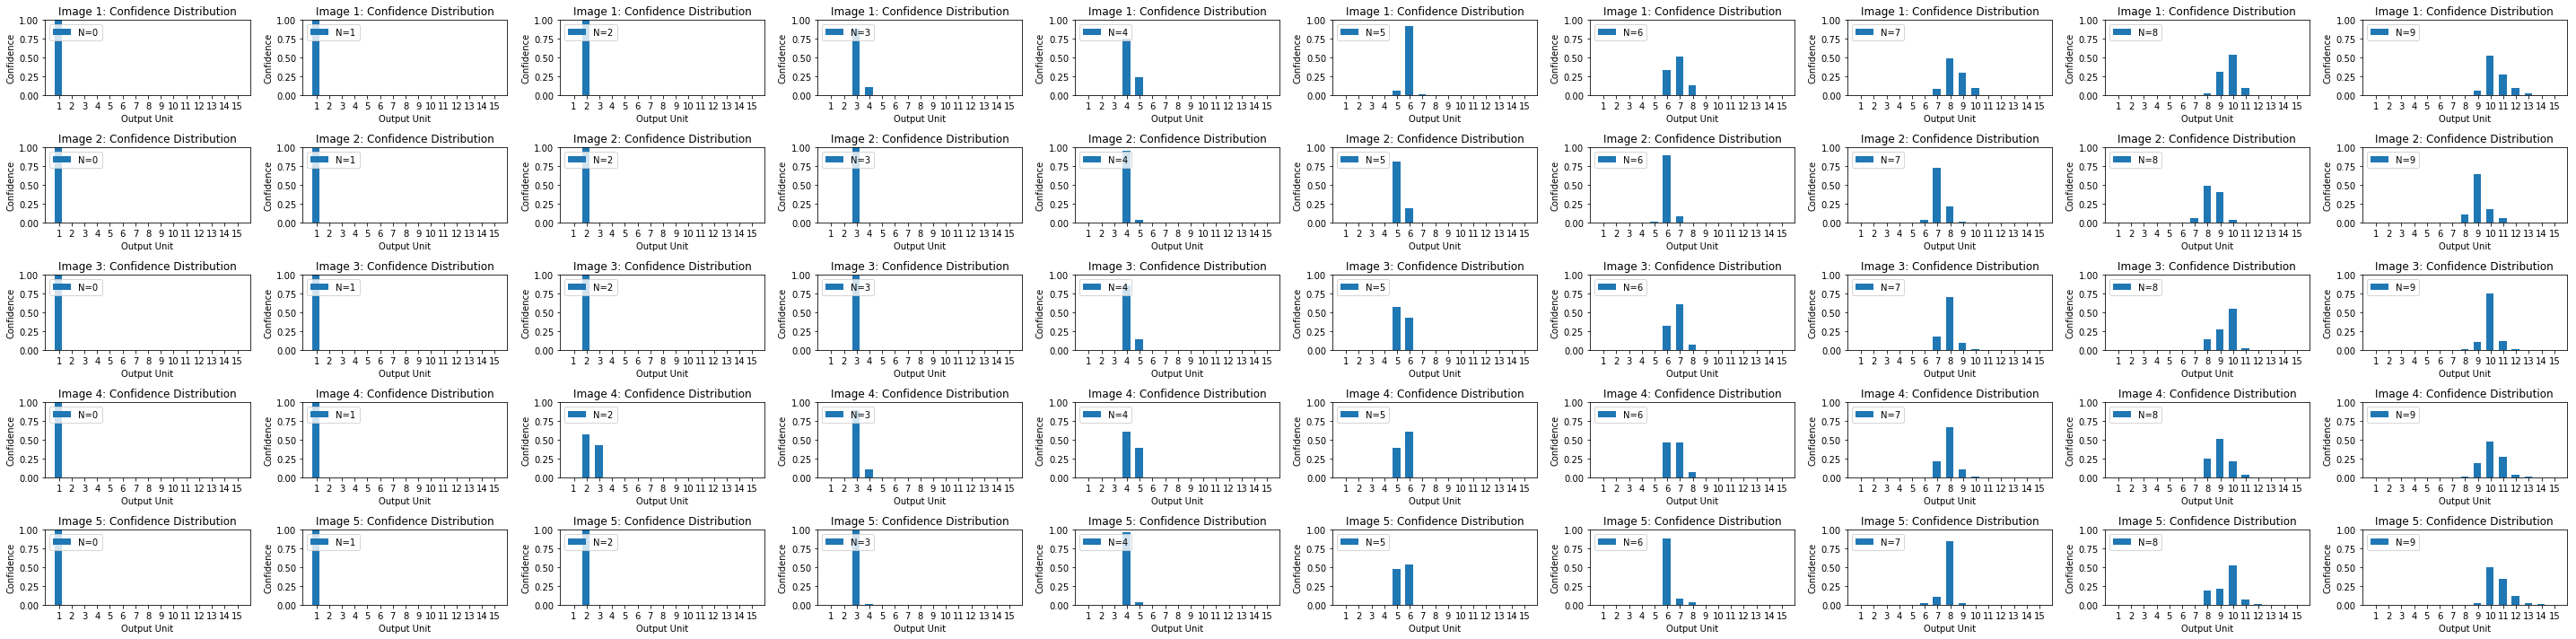

In [53]:
# Average Distribution of Choice across Runs
N_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
data = confidence
width=0.6
x = np.arange(1,16,1)

num_viz_imgs = 5
fig, axs = plt.subplots(num_viz_imgs, 10, figsize=(40,10))

for i in range(num_viz_imgs):
    for j in range(num_labels+1):
        axs[i][j].bar(x-width/14, data[i][j], width, label='N='+str(j))
        axs[i][j].set_title('Image '+str(i+1)+': Confidence Distribution')

        axs[i][j].set_xlabel('Output Unit')
        axs[i][j].set_ylabel('Confidence')
        axs[i][j].set_xticks(x)
        axs[i][j].set_xticklabels(N_labels)
        axs[i][j].legend(loc='upper left')
        
        axs[i][j].set_ylim(0, 1)
    
fig.tight_layout()
plt.show()